In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np 

In [2]:
X = np.load('datasets/X.npy')
Y = np.load('datasets/Y.npy')

In [3]:
N = X.shape[0]
sample_mean = np.mean(X[:N,:])
sample_std = np.std(X[:N,:])
sample_norm = (X[:N,:] - sample_mean)/sample_std # normalisation
X2 = sample_norm

In [4]:
X_flat = np.array(X2).reshape((2062, 64*64))
X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.3, random_state=42)

In [5]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 100, 100, 100), random_state=1)

## Bayesian GPLVM

In [6]:
import GPy

In [15]:
m = GPy.models.BayesianGPLVM(X_train, 20,  init="PCA",num_inducing=20)
m.data_labels = X_train.argmax(axis=1)
loss = m.optimize('bfgs', messages=1,max_iters=5000)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    08s63  0010   5.506243e+06   5.819455e+09 
    27s99  0032   5.344626e+06   5.460154e+08 
 01m23s25  0094   5.200333e+06   5.073706e+09 
 03m58s63  0266   5.109391e+06   3.651663e+07 
 11m16s51  0745   5.067910e+06   1.418468e+09 
 31m55s12  2076   5.053953e+06   2.015555e+05 
 37m42s81  2450   5.053533e+06   4.110861e+05 
Runtime:  37m42s81
Optimization status: Converged



 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


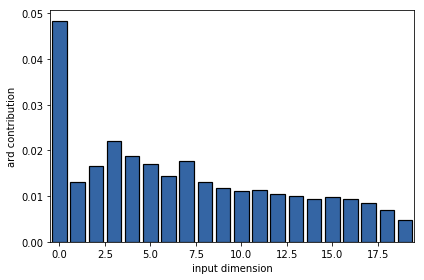

In [16]:
m.kern.plot_ARD()

In [17]:
clf.fit(m.X.mean,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [18]:
_,X_test_reduced = m.infer_newX(Y_new=X_test)

In [19]:
y_hat_reduced = clf.predict(X_test_reduced.X.mean)

In [20]:
print("accuracy: " + str(accuracy_score(y_test, y_hat_reduced)))

accuracy: 0.715670436187399


In [21]:
m.pickle('bgplvm_rbfd20.pickle')

In [22]:
X_test_back = m.predict(X_test_reduced.X.mean)

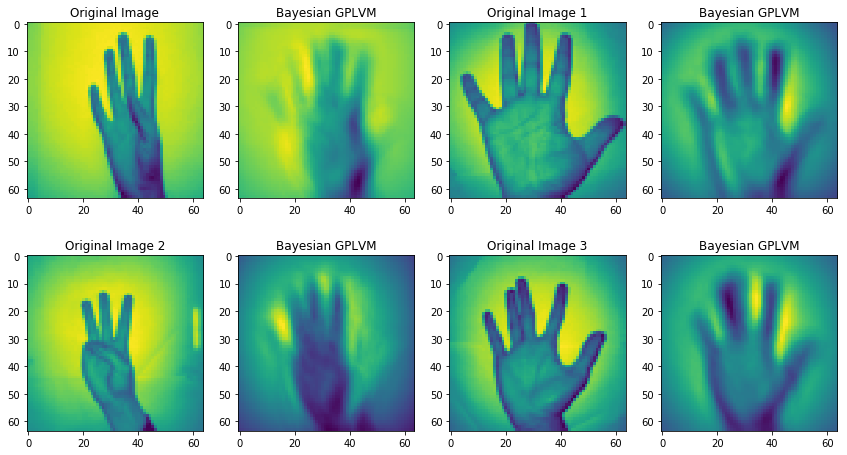

In [57]:
f = plt.figure()
f.add_subplot(5,4, 1)
plt.title("Original Image")
plt.imshow(X_test[0].reshape((64,64)))
f.add_subplot(5,4, 2)
plt.title("Bayesian GPLVM")
plt.imshow(X_test_back[0][0].reshape((64,64)))
f.add_subplot(5,4, 3)
plt.title("Original Image 1")
plt.imshow(X_test[1].reshape((64,64)))
f.add_subplot(5,4, 4)
plt.title("Bayesian GPLVM")
plt.imshow(X_test_back[0][1].reshape((64,64)))
f.add_subplot(5,4, 5)
plt.title("Original Image 2")
plt.imshow(X_test[2].reshape((64,64)))
plt.subplots_adjust(bottom=0.1, right=2, top=4)
f.add_subplot(5,4, 6)
plt.title("Bayesian GPLVM")
plt.imshow(X_test_back[0][2].reshape((64,64)))
f.add_subplot(5,4, 7)
plt.title("Original Image 3")
plt.imshow(X_test[3].reshape((64,64)))
f.add_subplot(5,4, 8)
plt.title("Bayesian GPLVM")
plt.imshow(X_test_back[0][3].reshape((64,64)))
plt.show(block=True)

In [27]:
from __future__ import absolute_import, division, print_function
import torch
from torch.distributions import constraints
from torch.nn import Parameter
import pyro
from pyro.contrib.gp.util import Parameterized
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
from pyro.params import param_with_module_name
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
pyro.clear_param_store()
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy
import math
import cProfile
import time
import GPy
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
import sympy as sp
#import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma
from GPy.core.parameterization.variational import NormalPosterior, NormalPrior

from sympy.interactive import printing
import pyro.contrib.gp.models.vsgp as vsgp
from GPy.util.linalg import pdinv
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc import MCMC
from matplotlib import pyplot
pyro.clear_param_store()
import time
torch.manual_seed(12)
pyro.set_rng_seed(101)

In [28]:
def initialize_latent(input_dim, Y):
    Xr = np.asfortranarray(np.random.normal(0, 1, (Y.shape[0], input_dim)))
    p = GPy.util.pca.PCA(Y)
    PC = p.project(Y, min(input_dim, Y.shape[1]))
    Xr[:PC.shape[0], :PC.shape[1]] = PC
    var = .1*p.fracs[:input_dim]
    Xr -= Xr.mean(0)
    Xr /= Xr.std(0)
    return Xr, var/var.max()

In [38]:
Xr, fracs = initialize_latent(15,X_train)

In [39]:
fracs = torch.tensor(1./fracs).float()

In [62]:
X_train_tens = torch.tensor(X_train.T).float()

In [61]:
X_train_tens.shape

torch.Size([4096, 1443])

In [41]:
# Load the Dataset
X_loc = torch.zeros(1443, 15)
kernel = gp.kernels.RBF(input_dim=15,lengthscale=fracs)
Xu = torch.zeros(20, 15)
gpmodel = gp.models.SparseGPRegression(X_loc, X_train_tens, kernel, Xu, noise=torch.tensor(1.))
gplvm = gp.models.GPLVM(gpmodel)

CPU+SystemTime:5611.421875 seconds
Code Run Time:1889.851791858673 seconds


Text(0.5,1,'Convergence of SVI')

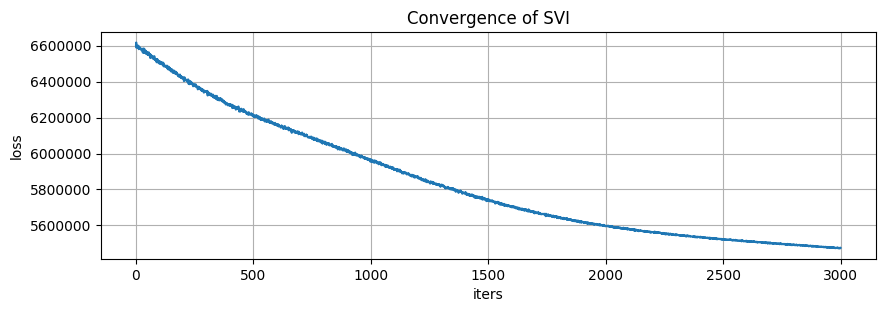

In [42]:
i=list(range(1,3001))
st = time.process_time()
st2 = time.time()
losses = gplvm.optimize(num_steps=3000)  # doctest: +SKIP
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
pyplot.title('Convergence of SVI')


In [90]:
#X_train_tens.shape[1:]

In [89]:
#torch.tensor(X_test.T).float().shape[1:]

In [91]:
#gplvm.base_model. 

In [92]:
#gplvm.base_model.mean_function(x=torch.tensor(X_test.T).float())

In [93]:
#gplvm.base_model(torch.tensor(X_test.T).float())

In [94]:
#f_loc = gplvm.base_model.forward(Xnew=torch.tensor(X_test.T).float())